In [2]:
# basic
import pandas as pd
import numpy as np
from cupy import asnumpy
from joblib import dump, load
# geo 
import rasterio
# from rasterio.mask import mask
#import geowombat as gw
import geopandas as gpd
from shapely import box
# plot
import seaborn as sns
import matplotlib.pyplot as plt
# from rasterio.plot import show

# sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
#cuML
import cuml
from cuml.ensemble import RandomForestClassifier as cuRF
# from cuml.model_selection import train_test_split
# from cuml.datasets.classification import make_classification

# raster
import rasterio.windows
from rasterio.windows import from_bounds


In [3]:
#define satellite image and training data paths
rgb_vi_DQ=r"\\?\E:\AWAP\22FEB15073634-S2AM-RCRC-4Bands-8b.TIF"
DQTraining = r'/mnt/d/Dropbox/P.Robeck/BPLA Dropbox/03 Planning/DQ-Vegetation-Analysis-1180/03_Data/06-Land-cover-classification/LCC analyses/Land-cover-classification-v4/training-RUH-centroid-2.gpkg'

out=r"/mnt/e/AWAP/22FEB15073634-S2AM-RCRC-4Bands-8b.TIF"
out_pre=r"/mnt/e/AWAP/22FEB15073634-S2AM-RCRC-4Bands-v2.TIF"

train = gpd.read_file(DQTraining)
train = train.to_crs(32638) #from crs to another
train = train.explode() #from multipolygons topolygons
train

/tmp/ipykernel_8754/363175965.py:10: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  train = train.explode() #from multipolygons topolygons


,,class,geometry
0,0,shadow,POINT (664487.922 2732281.425)
1,0,palm,POINT (664582.625 2732254.175)
2,0,palm,POINT (664658.927 2732274.140)
3,0,palm,POINT (664522.855 2732302.311)
4,0,ground,POINT (664410.619 2730140.042)
...,...,...,...
4784,0,ground,POINT (665588.495 2732163.570)
4785,0,ground,POINT (666211.025 2732888.835)
4786,0,ground,POINT (666220.687 2732894.793)
4787,0,ground,POINT (666224.551 2732870.961)


In [4]:
def sample_image(src_img, training):
    with rasterio.open(src_img) as src:
        res=[]
        temp = [training['geometry'].x, training['geometry'].y]
        coords = list(map(list, zip(*temp)))
        
        for val in src.sample(coords): 
            res.append(val)
    return (res)

In [5]:
ts = sample_image(out, train) 
train[["blue", "green", "red","nir","arvi","evi","ndvi","savi"]] = ts

In [6]:
classmap =dict(enumerate(train['class'].unique()))
classmap = {value: key for key, value in classmap.items()}
train['lc']=train['class'].map(classmap)

           blue     green       red       nir      arvi       evi      ndvi  \
blue   1.000000  0.984428  0.956782  0.434653  0.029296  0.033935 -0.018577   
green  0.984428  1.000000  0.982211  0.518465  0.033273  0.033911 -0.032208   
red    0.956782  0.982211  1.000000  0.492866  0.027460  0.031954 -0.033527   
nir    0.434653  0.518465  0.492866  1.000000  0.071438  0.051083 -0.135904   
arvi   0.029296  0.033273  0.027460  0.071438  1.000000 -0.006259 -0.005339   
evi    0.033935  0.033911  0.031954  0.051083 -0.006259  1.000000 -0.030044   
ndvi  -0.018577 -0.032208 -0.033527 -0.135904 -0.005339 -0.030044  1.000000   
savi  -0.013067 -0.017657 -0.020091 -0.058749 -0.010128 -0.019158  0.986838   

           savi  
blue  -0.013067  
green -0.017657  
red   -0.020091  
nir   -0.058749  
arvi  -0.010128  
evi   -0.019158  
ndvi   0.986838  
savi   1.000000  


<Axes: >

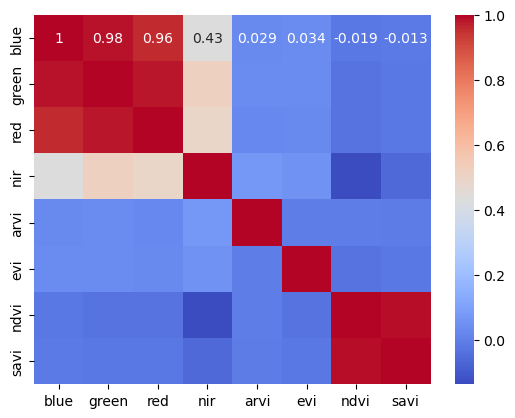

In [7]:
print(train[["blue", "green", "red","nir","arvi","evi","ndvi","savi"]].corr())
sns.heatmap(train[["blue", "green", "red","nir","arvi","evi","ndvi","savi"]].corr(), annot=True, cmap='coolwarm')

In [8]:
# Create different dataframes for each class
df_class_0 = train[train['lc'] == 0]
df_class_1 = train[train['lc'] == 1]
df_class_2 = train[train['lc'] == 2]
df_class_3 = train[train['lc'] == 3]
df_class_4 = train[train['lc'] == 4]
#df_class_5 = training_samples[training_samples['lc'] == 5]

# Find the size of the majority class
majority_class_size = max(len(df_class_0), len(df_class_1), len(df_class_2), len(df_class_3), len(df_class_4)) #min
# majority_class_size = 5000
# Upsample minority classes to match the size of the majority class
df_class_0_upsampled = resample(df_class_0,
                                replace=True,    # sample with replacement
                                n_samples=majority_class_size,  # to match majority class size
                                random_state=1234) # reproducible results

df_class_1_upsampled = resample(df_class_1,
                                replace=True,
                                n_samples=majority_class_size,
                                random_state=1234)

df_class_2_upsampled = resample(df_class_2,
                                replace=True,
                                n_samples=majority_class_size,
                                random_state=1234)

df_class_3_upsampled = resample(df_class_3,
                                replace=True,
                                n_samples=majority_class_size,
                                random_state=1234)

df_class_4_upsampled = resample(df_class_4,
                                replace=True,
                                n_samples=majority_class_size,
                                random_state=1234)

# Combine upsampled classes to create the final upsampled dataframe
df_upsampled = pd.concat([df_class_0_upsampled, df_class_1_upsampled, df_class_2_upsampled, df_class_3_upsampled, df_class_4_upsampled])

# Shuffle the dataframe to mix the classes
df_upsampled = df_upsampled.sample(frac=1, random_state=1234).reset_index(drop=True)

In [9]:
# Assign class labels based on your training data
target = df_upsampled['lc'].values
data_in = df_upsampled[['blue', 'green', 'red', 'nir', 'arvi', 'evi', 'ndvi','savi']]
# data_in = df_upsampled[[ 'arvi', 'evi', 'ndvi']]
data_in = data_in.astype(float)
X_train, X_val, y_train, y_val = train_test_split(data_in, target, test_size=0.1, random_state=42)

In [10]:
df_upsampled

,class,geometry,blue,green,red,nir,arvi,evi,ndvi,savi,lc
0,tree,POINT (663419.400 2730530.600),19.0,13.0,1.0,130.0,0.828221,-58.636364,0.984733,1.471483,4
1,palm,POINT (664063.050 2731859.900),32.0,31.0,26.0,157.0,0.536585,-1.799451,0.715847,1.070845,1
2,building,POINT (664298.399 2732171.900),215.0,219.0,205.0,188.0,3.983051,-0.405497,1.744526,2.607273,3
3,tree,POINT (665008.211 2730525.212),37.0,40.0,37.0,88.0,0.237624,-0.573034,0.408000,0.609562,4
4,shadow,POINT (664581.182 2730963.504),16.0,12.0,4.0,12.0,0.272727,-0.240964,0.500000,0.727273,0
...,...,...,...,...,...,...,...,...,...,...,...
7850,ground,POINT (663001.118 2734329.038),33.0,55.0,28.0,56.0,0.034884,-3.111111,0.333333,0.497041,2
7851,tree,POINT (663262.158 2729047.879),55.0,62.0,66.0,150.0,1.000000,-0.556291,0.388889,0.581986,4
7852,shadow,POINT (665666.110 2731413.989),27.0,19.0,11.0,4.0,0.016393,-4.733840,16.600000,24.096775,0
7853,shadow,POINT (664483.560 2731183.079),18.0,15.0,5.0,19.0,0.298246,-0.411765,0.583333,0.857143,0


In [24]:
model = cuRF(n_estimators=25, max_depth=35, random_state=42, n_streams=1, split_criterion=1, n_bins=45, max_features='log2') #max_features, n_jobs, criterion, depth, estimators
model.fit(X_train.astype(float), y_train.astype(float))
predicted = model.predict(X_val.astype(float))

cu_score = cuml.metrics.accuracy_score(y_val.astype(float), predicted)
cu_score

0.919847309589386

# Optimise parameters

In [126]:
%%time
res=[]

dataraw=pd.DataFrame(data={'i': [0], 'j': [0],'k':[ 0],'cu': [0]}) 
est = range(102,107, 1)
dep = range(23,27,1)
bins = range(40, 50, 1)

for i in (est):
    for j in (dep):
        for k in (bins):
            model = cuRF(n_estimators=i, max_depth=j, random_state=42, n_streams=1, split_criterion=1, n_bins=k,max_features='log2') #max_features, n_jobs, criterion, depth, estimators
            model.fit(X_train.astype(float), y_train.astype(float))
            predicted = model.predict(X_val.astype(float))

            cu_score = cuml.metrics.accuracy_score(y_val.astype(float), predicted)

            res.append({'i': i, 'j': j,'k':k,'cu': cu_score})
            
            # print(i,j,k, cu_score)
            
pd.DataFrame(res).sort_values(by=['cu','i','j','k'],ascending=[False,True,True,True])

/home/phil/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


102 23 40 0.9160305261611938
102 23 41 0.9045801758766174
102 23 42 0.9160305261611938
102 23 43 0.910941481590271
102 23 44 0.8956742882728577
102 23 45 0.9173027873039246
102 23 46 0.9058524370193481
102 23 47 0.9071246981620789
102 23 48 0.9122137427330017
102 23 49 0.9160305261611938
102 24 40 0.9160305261611938
102 24 41 0.9033079147338867
102 24 42 0.9160305261611938
102 24 43 0.910941481590271
102 24 44 0.8956742882728577
102 24 45 0.919847309589386
102 24 46 0.9058524370193481
102 24 47 0.9083969593048096
102 24 48 0.9122137427330017
102 24 49 0.9160305261611938
102 25 40 0.9147582650184631
102 25 41 0.9033079147338867
102 25 42 0.9185750484466553
102 25 43 0.910941481590271
102 25 44 0.8956742882728577
102 25 45 0.919847309589386
102 25 46 0.9058524370193481
102 25 47 0.9083969593048096
102 25 48 0.9122137427330017
102 25 49 0.9160305261611938
102 26 40 0.9160305261611938
102 26 41 0.9033079147338867
102 26 42 0.9185750484466553
102 26 43 0.9122137427330017
102 26 44 0.8969465

,i,j,k,cu
195,106,26,45,0.922392
35,102,26,45,0.921120
105,104,25,45,0.921120
115,104,26,45,0.921120
155,105,26,45,0.921120
...,...,...,...,...
14,102,24,44,0.895674
24,102,25,44,0.895674
44,103,23,44,0.895674
54,103,24,44,0.895674


Confusion Matrix RF: 
 [[175   0   0   0   0]
 [  0 135   5   1   6]
 [  1   4 133   1   3]
 [  4   0   1 158   0]
 [  0  24  10   1 124]]
[[0.22264631 0.         0.         0.         0.        ]
 [0.         0.17175573 0.00636132 0.00127226 0.00763359]
 [0.00127226 0.00508906 0.1692112  0.00127226 0.00381679]
 [0.00508906 0.         0.00127226 0.20101781 0.        ]
 [0.         0.03053435 0.01272265 0.00127226 0.15776081]]


<module 'matplotlib.pyplot' from '/home/phil/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/matplotlib/pyplot.py'>

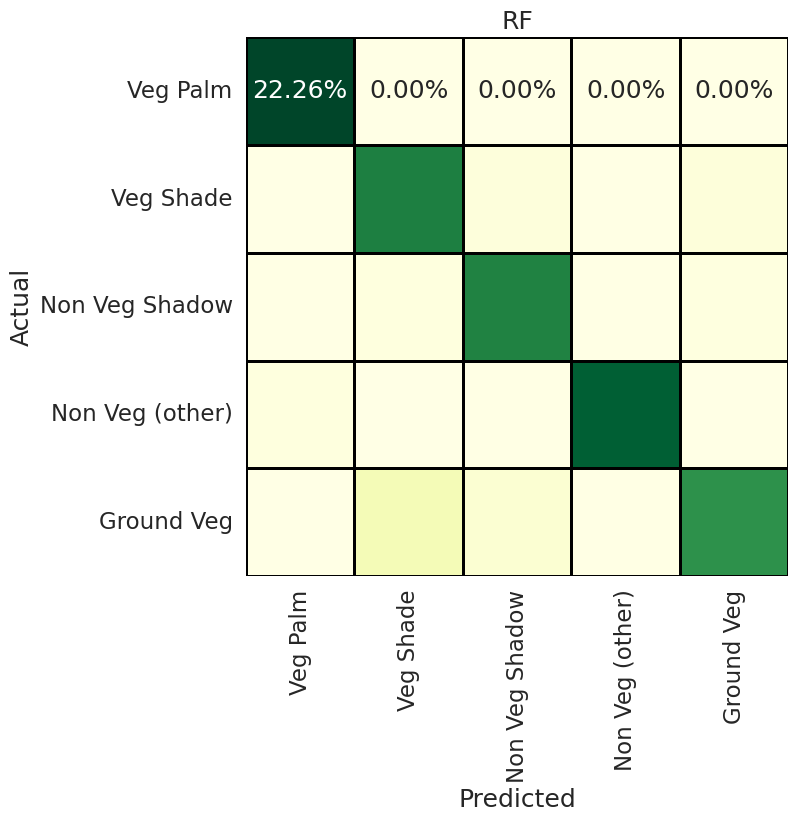

In [136]:
# land cover names (for post visualization)

lulc_name = ['Veg Palm', 'Veg Shade', 'Non Veg Shadow', 'Non Veg (other)', 'Ground Veg']
threshold = 0.1
# y_pred_thresholded = np.where(predicted > threshold, 1, 0)
# Confusion Matrix / error matrix
cm = cuml.metrics.confusion_matrix(y_val, predicted.astype(int))
# cm = confusion_matrix(y_val, y_pred_thresholded)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)
print(cm_percent.get())
plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent.get(),
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title('RF')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt

# Prediction

In [26]:
def process_image(src_img, dst_img, band_id=1):
    with rasterio.open(src_img) as src:

        tiles = src.block_windows(band_id)
        profile = src.profile
        p_count = src.shape[0]*src.shape[1]
        # ndval = src.nodatavals[0]
        # print(ndval)
        profile.update(
            dtype=rasterio.uint8,
            count=1,
            compress='lzw',
            BIGTIFF = "IF_SAFER")
        with rasterio.open(dst_img, 'w', **profile) as dst:
            for idx, window in tiles:
                # print("Processing Block: ", idx[0]+1, ", ", idx[1]+1)
                
                # dst_data = src.read(band_id, window=window) #read all 7 bands
                # read bands
                band1 = src.read(1, window=window)
                band2 = src.read(2, window=window)
                band3 = src.read(3, window=window)
                band4 = src.read(4, window=window)
                band5 = src.read(5, window=window)
                band6 = src.read(6, window=window)
                band7 = src.read(7, window=window)
                band8 = src.read(8, window=window)
                print(((((idx[0]+1)*band1.shape[0]*band1.shape[1])/p_count)*100))
                # convert numpy
                npbands = np.array([band1, band2, band3, band4, band5, band6, band7, band8])
                np.nan_to_num(npbands, copy=False)
                npbands = pd.DataFrame(npbands.reshape([8,-1]).T)
                # print(npbands.head)

                

                npbands.columns = ['blue', 'green', 'red', 'nir', 'arvi', 'EVI', 'NDVI','SAVI']
                        
                # do predict
                out = model.predict(npbands)
                
                # reconvert to raster with georef
                # pred_raster_int = np.unique(out, return_inverse = True)[1]
                
                height, width = band1.shape
                pred_raster = np.array(out).reshape((height, width))
                
                # write with rasterio
                dst.write_band(band_id, pred_raster, window=window)
    return

In [27]:
%%time
# out=r"/mnt/e/AWAP/22FEB15073634-S2AM-RCRC-4Bands-VIND.TIF"
out_pre=r"/mnt/e/AWAP/22FEB15073634-S2AM-RCRC-4Bands-RF6.1.TIF"

process_image(out,out_pre) 

0.0007273203336945691
0.0014546406673891382
0.0021819610010837074
0.0029092813347782764
0.0036366016684728454
0.004363922002167415
0.005091242335861984
0.005818562669556553
0.006545883003251122
0.007273203336945691
0.00800052367064026
0.00872784400433483
0.009455164338029398
0.010182484671723968
0.010909805005418537
0.011637125339113106
0.012364445672807676
0.013091766006502244
0.013819086340196811
0.014546406673891382
0.01527372700758595
0.01600104734128052
0.016728367674975087
0.01745568800866966
0.018183008342364228
0.018910328676058796
0.019637649009753365
0.020364969343447937
0.021092289677142505
0.021819610010837074
0.022546930344531643
0.02327425067822621
0.02400157101192078
0.02472889134561535
0.025456211679309917
0.02618353201300449
0.026910852346699057
0.027638172680393622
0.028365493014088194
0.029092813347782763
0.029820133681477335
0.0305474540151719
0.031274774348866476
0.03200209468256104
0.03272941501625561
0.033456735349950174
0.03418405568364475
0.03491137601733932
0.

In [ ]:
120174/274982

# raster stats

res=pd.DataFrame()

def stats(src_img, band_id=1):
    with rasterio.open(src_img) as src:
        tiles = src.block_windows(band_id)
        out_profile = src.profile
        ndval = src.nodatavals[0]
        print(ndval)
        srcshape=out_profile.height*out_profile.width
        out_profile.update(
            dtype=rasterio.int16,
            count=1,
            nodata=-9,
            nodatavals=-9,
            compress='lzw')
       
        for idx, window in tiles:
            data = src.read(band_id, window=window)
            print(((((idx[0]+1)*data.shape[0]*data.shape[1])/srcshape)*100))
            
            uni = pd.DataFrame(np.unique(data, return_counts=True))
            uni.columns = uni.iloc[0]
            uni = uni[1:]
            res= pd.concat([res, uni], join='outer')
            res=pd.DataFrame(res.sum(axis=0)).T
            
            
        

    return(res)